# Data2060 final project Report
# Classification And Regression Tree(CART) for regression on airfield dataset

authors:
JunHe Chen, Han Huang, JunWei Su,XuanYao Qian,

GitHub Link: https://github.com/Pafuuuu/Brown_Data2060_Final_Project/tree/main

In [1]:

from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.11"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.11"):
    print(FAIL, "Python version 3.12.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'matplotlib': "3.10.5", 'numpy': "2.3.2",'sklearn': "1.7.1", 
                'pandas': "2.3.2", 'pytest': "8.4.1", 'torch':"2.7.1"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.11

[ OK ] matplotlib version 3.10.5 is installed.
[ OK ] numpy version 2.3.2 is installed.
[ OK ] sklearn version 1.7.1 is installed.
[ OK ] pandas version 2.3.2 is installed.
[ OK ] pytest version 8.4.1 is installed.
[ OK ] torch version 2.7.1 is installed.



# SECTION 1: OVERVIEW — CART Regression

This project implements a from-scratch regression tree based on the CART (Classification and Regression Trees) algorithm, using only NumPy and no external machine learning libraries. The goal is to replicate the core behavior of sklearn.tree.DecisionTreeRegressor while maintaining full transparency over every algorithmic step, including impurity computation, split selection, stopping criteria, and prediction logic.

By building the model manually, this project emphasizes a deep understanding of decision tree mechanics, numerical considerations, and the design choices that affect predictive behavior and model stability.

Motivation

While libraries such as scikit-learn provide highly optimized tree implementations, their internal logic is abstracted away behind compiled code. This project addresses that limitation by:

- Exposing the exact CART optimization objective

- Making split selection and stopping behavior explicit

- Allowing precise control over determinism, tie-breaking, and numerical tolerances

- Enabling direct comparison with sklearn’s implementation

- The result is an interpretable, educational model that closely mirrors a production-grade decision tree while remaining fully inspectable.

The CART methodology was originally formalized by Breiman, Friedman, Olshen, and Stone (1984) and has since become a foundational approach for nonparametric supervised learning. A comprehensive exposition of CART theory and applications is provided by Timofeev (2004), who presents a detailed treatment of both classification and regression trees, including impurity measures, splitting rules, and pruning strategies . The work emphasizes the greedy, top-down construction of maximum trees based on impurity reduction and highlights the critical role of pruning—via minimum node size or cost-complexity criteria—in controlling overfitting.

## 1.1 Representation: How Features Become Predictions

A CART regression tree builds a **piecewise-constant** function
$$
\hat{f} : \mathbb{R}^d \to \mathbb{R}
$$
by recursively partitioning the input space into axis-aligned regions
$$
R_1, R_2, \dots, R_M, \qquad R_i \subset \mathbb{R}^d, \quad R_i \cap R_j = \emptyset.
$$

Each region corresponds to a leaf node in the tree, and the prediction is a constant value on that region.

A root-to-leaf path is a sequence of binary tests of the form
$$
x_{j_k} \le t_k,
$$
and the set of all points following the same path forms a region $R_m$.
The tree implements a function
$$
\hat{f}(x) = \sum_{m=1}^M c_m \mathbf{1}{x \in R_m},
$$
where the constant prediction on region $R_m$ is the mean of the training labels that fall into that region:
$$
c_m = \frac{1}{|R_m|}\sum_{i : x_i \in R_m} y_i.
$$

Thus, the **representation** is:
1. A partition of feature space into regions $R_m$ defined by axis-aligned splits.
2. A constant value $c_m$ per region, estimated as the average of targets in that region.

This yields an interpretable model where each prediction is obtained by following a sequence of feature-threshold decisions down the tree.

---

## 1.2 Loss: Measuring Prediction Error via Impurity

At each node, CART measures the quality of a set of targets $S = {y_i}_{i=1}^n$ using **Mean Squared Error (MSE)** impurity:
$$
I(S) = \frac{1}{|S|} \sum_{i \in S} (y_i - \bar{y})^2,
\qquad
\bar{y} = \frac{1}{|S|} \sum_{i \in S} y_i.
$$

Given a candidate split on feature $j$ at threshold $t$,
$$
S_L = {i : x_{ij} \le t}, \qquad S_R = {i : x_{ij} > t},
$$
the post-split impurity is
$$
I_{\text{child}}(j,t) =
\frac{|S_L|}{|S|} I(S_L) +
\frac{|S_R|}{|S|} I(S_R).
$$

The **impurity reduction** (also called "gain") is
$$
\Delta I(j,t) = I(S) - I_{\text{child}}(j,t).
$$

Equivalently, on the whole tree, the training loss is the MSE between the piecewise-constant tree prediction and the targets:
$$
\mathcal{L}(\hat{f}) = \frac{1}{N}\sum_{i=1}^N \bigl(y_i - \hat{f}(x_i)\bigr)^2.
$$

---

## 1.3 Optimizer: Greedy Search for Splits

Unlike linear models or neural networks, CART does **not** optimize a continuous parameter vector with gradient descent.  
Instead, it searches over:

- Which feature $j$ to split on at each node.
- Which threshold $t$ to use for that feature.
- How deep to grow the tree.

At each non-leaf node, CART solves the discrete optimization problem
$$
(j^*, t^*) = \text{arg max}_{j,t} \Delta I(j,t).
$$

The search is performed greedily with a **top-down recursive binary splitting** procedure:

```text
BuildTree(S, depth):
    if stopping criterion is satisfied:
        return Leaf(mean(targets in S))

    best_gain = 0
    best_feature, best_threshold = None, None

    for each feature j:
        for each candidate threshold t:
            compute impurity reduction ΔI(j, t)
            if ΔI(j, t) > best_gain:
                update best_gain, best_feature, best_threshold

    if best_feature is None:
        return Leaf(mean(targets in S))

    split S into S_L, S_R using best_feature and best_threshold
    left_child  = BuildTree(S_L, depth + 1)
    right_child = BuildTree(S_R, depth + 1)

    return Node(best_feature, best_threshold, left_child, right_child)
```

The **stopping criteria** typically involve:

- Maximum depth: $\text{depth} \ge \text{max\_depth}$
- Minimum samples to split: $|S| < \text{min\_samples\_split}$
- Minimum samples per leaf: $|S_L|, |S_R| < \text{min\_samples\_leaf}$
- Minimum impurity decrease: $\Delta I(j,t) < \text{min\_impurity\_decrease}$

This greedy algorithm approximately minimizes the training MSE by repeatedly choosing locally optimal splits.

---

## 1.4 Advantages and Disadvantages

**Advantages**

- Interpretable: predictions can be explained by simple rules ("if feature j ≤ t").
- Handles nonlinear relationships and feature interactions.
- Works with unscaled, mixed-type features (after encoding categories).
- Forms the base learner for powerful ensembles (Random Forests, Gradient Boosting).

**Disadvantages**

- High variance: small changes in data can lead to very different trees.
- Piecewise-constant predictions are discontinuous and can be unstable.
- Greedy local optimization does not guarantee a globally optimal tree.
- Without depth limits or pruning, trees can severely overfit.


In [2]:

# SECTION 2: MODEL — CARTRegressor (numpy only)

import numpy as np

class TreeNode:
    """A single node in the regression tree.

    Parameters
    ----------
    feature : int or None
        Index of feature used for the split. None if leaf node.
    threshold : float or None
        Threshold value for the split. None if leaf node.
    left : TreeNode or None
        Left child node.
    right : TreeNode or None
        Right child node.
    value : float or None
        Constant prediction value if this is a leaf node.
    depth : int
        Depth of the node in the tree (root = 0).
    n_node_samples : int
        Number of samples reaching this node.
    """
    def __init__(self, *, feature=None, threshold=None,
                 left=None, right=None, value=None,
                 depth=0, n_node_samples=0):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.depth = depth
        self.n_node_samples = n_node_samples


class CARTRegressor:
    """A numpy-only implementation of CART Regression Trees.

    This class implements a subset of sklearn.tree.DecisionTreeRegressor,
    following the CART algorithm described in Breiman et al. (1984).

    Parameters
    ----------
    max_depth : int or None
        Maximum allowable depth of the tree (None → unlimited).
    min_samples_split : int or float
        Minimum number of samples required to attempt a split.
    min_samples_leaf : int or float
        Minimum number of samples allowed in each leaf.
    max_features : int, float, 'sqrt', 'log2', or None
        Number of features to consider for splitting.
    splitter : {'best', 'random'}
        Strategy for selecting candidate split thresholds.
    min_impurity_decrease : float
        Minimum impurity reduction required to allow a split.
    random_state : int or None
        Seed for reproducible randomness.
    """

    def __init__(self, *, max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, max_features=None,
                 splitter='best', min_impurity_decrease=0.0,
                 random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.splitter = splitter
        self.min_impurity_decrease = float(min_impurity_decrease)
        self.random_state = random_state
        self.rng_ = np.random.RandomState(random_state)

    # -------------------------------------------------------------
    #                       HELPER METHODS
    # -------------------------------------------------------------
    def _impurity(self, y):
        """Compute mean squared error impurity for a node.

        Parameters
        ----------
        y : ndarray of shape (n_samples,)

        Returns
        -------
        float
            Node impurity = MSE(y)
        """
        if y.size == 0:
            return 0.0
        mu = y.mean()
        return float(((y - mu) ** 2).mean())

    def _leaf_value(self, y):
        """Compute leaf prediction value: mean of y.

        Parameters
        ----------
        y : ndarray

        Returns
        -------
        float
        """
        return float(np.mean(y))

    def _resolve_min_samples(self, n):
        """Convert min_samples_split and min_samples_leaf into absolute integers.

        Handles both int and float (fraction) specifications.

        Parameters
        ----------
        n : int
            Total number of samples at root.

        Returns
        -------
        (mss, msl) : tuple of ints
        """
        mss = self.min_samples_split
        if isinstance(mss, float):
            mss = int(np.ceil(mss * n))
        mss = max(2, int(mss))

        msl = self.min_samples_leaf
        if isinstance(msl, float):
            msl = int(np.ceil(msl * n))
        msl = max(1, int(msl))

        return mss, msl

    def _get_feature_indices(self):
        """Select a subset of features according to max_features.

        Returns
        -------
        ndarray of selected feature indices
        """
        n = self.n_features_in_
        mf = self.max_features

        # Convert specification to numeric count
        if mf is None:
            k = n
        elif isinstance(mf, int):
            k = mf
        elif isinstance(mf, float):
            k = max(1, int(mf * n))
        elif mf == "sqrt":
            k = max(1, int(np.sqrt(n)))
        elif mf == "log2":
            k = max(1, int(np.log2(n)))
        else:
            raise ValueError("Invalid max_features")

        k = min(k, n)

        # Randomly shuffle and return the first k
        idx = np.arange(n)
        self.rng_.shuffle(idx)
        return idx[:k]

    def _best_split(self, X, y, min_leaf):
        """Find the best split across all selected features.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
        y : ndarray, shape (n_samples,)
        min_leaf : int
            Minimum samples required in each leaf.

        Returns
        -------
        (best_feature, best_threshold, best_impurity_improvement)
        """
        n = len(y)
        parent_impurity = self._impurity(y)

        best_feature = None
        best_threshold = None
        best_gain = 0.0
        
        for j in self._get_feature_indices():
            col = X[:, j]
            uniq = np.unique(col)
            if len(uniq) <= 1:
                continue

            uniq_sorted = np.sort(uniq)
            # candidate thresholds = midpoints between consecutive unique values
            midpoints = (uniq_sorted[1:] + uniq_sorted[:-1]) / 2.0

            # Determine threshold candidates
            if self.splitter == 'best':
                candidates = midpoints
            else:  # random splitter
                m = max(1, int(np.sqrt(len(midpoints))))
                idx = self.rng_.choice(len(midpoints), m, replace=False)
                candidates = midpoints[idx]

            # Scan thresholds
            for t in candidates:
                L = col <= t
                R = ~L
                if L.sum() < min_leaf or R.sum() < min_leaf:
                    continue

                child_imp = (L.sum() / n) * self._impurity(y[L]) + (R.sum() / n) * self._impurity(y[R])
                gain = parent_impurity - child_imp

                if gain > best_gain:
                    best_gain = gain
                    best_feature = j
                    best_threshold = float(t)

        return best_feature, best_threshold, best_gain

    def _build(self, X, y, depth):
        """Recursively build the tree.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
        y : ndarray, shape (n_samples,)
        depth : int
            Current depth.

        Returns
        -------
        TreeNode
        """
        n = len(y)
        value = self._leaf_value(y)

        # Check stopping conditions
        if (self.max_depth is not None and depth >= self.max_depth) or (n < self.min_samples_split_):
            return TreeNode(value=value, depth=depth, n_node_samples=n)

        f, t, gain = self._best_split(X, y, self.min_samples_leaf_)
        if f is None or gain < self.min_impurity_decrease:
            return TreeNode(value=value, depth=depth, n_node_samples=n)

        L = X[:, f] <= t
        R = ~L

        left = self._build(X[L], y[L], depth + 1)
        right = self._build(X[R], y[R], depth + 1)

        return TreeNode(feature=f, threshold=t,
                        left=left, right=right,
                        depth=depth, n_node_samples=n)

    # -------------------------------------------------------------
    #                      PUBLIC API METHODS
    # -------------------------------------------------------------
    def fit(self, X, y):
        """Fit a CART regression tree to the training data.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
        y : ndarray of shape (n_samples,)

        Returns
        -------
        self
        """
        X = np.asarray(X, float)
        y = np.asarray(y, float)

        self.n_samples_, self.n_features_in_ = X.shape
        self.min_samples_split_, self.min_samples_leaf_ =  self._resolve_min_samples(self.n_samples_)

        self.root_ = self._build(X, y, depth=0)
        return self

    def _predict_one(self, x, node):
        """Traverse the tree to compute the prediction for a single sample."""
        if node.value is not None:
            return node.value
        return self._predict_one(
            x,
            node.left if x[node.feature] <= node.threshold else node.right
        )

    def predict(self, X):
        """Predict regression output for the input samples.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)

        Returns
        -------
        ndarray of predictions
        """
        X = np.asarray(X, float)
        return np.array([self._predict_one(row, self.root_) for row in X])

    @staticmethod
    def mse(y_true, y_pred):
        """Compute mean squared error between y_true and y_pred."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        return float(((y_true - y_pred) ** 2).mean())


In [3]:
# SECTION 3: CHECK MODEL — Unit Tests + sklearn comparison + Airfield dataset

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# ------------------------------------------------------------
# TEST 1: Impurity computation
# ------------------------------------------------------------
# Goal: verify correct MSE impurity computation including edge cases.

m = CARTRegressor()

y_const = np.array([5, 5, 5], float)
y_var   = np.array([1, 2, 3], float)

# Constant vector → impurity must be zero
assert abs(m._impurity(y_const) - 0.0) < 1e-12, \
    "Impurity must be zero for a constant vector."

# General case → impurity equals population variance (ddof=0)
assert abs(m._impurity(y_var) - np.var(y_var, ddof=0)) < 1e-12, \
    "Impurity should equal the variance of y."

# Empty vector edge case
assert m._impurity(np.array([], float)) == 0.0, \
    "Impurity of an empty array should be 0.0."

print("[TEST 1 PASSED] impurity function correct.")


# ------------------------------------------------------------
# TEST 2: Leaf value computation
# ------------------------------------------------------------
# Goal: ensure leaf node prediction equals mean of y values.

y = np.array([10, 20, 30, 40], float)
assert m._leaf_value(y) == 25.0, "Leaf prediction must equal mean(y)."

print("[TEST 2 PASSED] leaf value correct.")


# ------------------------------------------------------------
# TEST 3: Best split detection
# ------------------------------------------------------------
# Goal: verify _best_split finds an impurity-reducing split
# that perfectly separates the two groups.

X_toy = np.array([[1], [2], [10], [11]], float)
y_toy = np.array([1, 1, 10, 10], float)

test_model = CARTRegressor(max_depth=2, random_state=0)
test_model.n_features_in_ = 1  # needed before calling _best_split

f, t, g = test_model._best_split(X_toy, y_toy, min_leaf=1)

# Must split on the only feature
assert f == 0, "Must split on the only feature."

# Apply the split and check the groups
L = X_toy[:, 0] <= t
R = ~L

assert L.sum() == 2 and R.sum() == 2, \
    "Split should divide data into two non-empty groups of size 2."

# The split should separate the labels into two pure regions
assert np.all(y_toy[L] == 1) and np.all(y_toy[R] == 10), \
    "Best split should separate y into two pure groups: [1,1] and [10,10]."

# Impurity reduction must be positive
assert g > 0, "Split must reduce impurity."

print("[TEST 3 PASSED] best split detection correct.")


# ------------------------------------------------------------
# TEST 4: Prediction traversal
# ------------------------------------------------------------
# Goal: verify predictions follow correct node routing.

tree = CARTRegressor(max_depth=1, random_state=0).fit(X_toy, y_toy)
pred = tree.predict(X_toy)

# Points on the left side of the split should share the same prediction
assert pred[0] == pred[1], "Left region must predict the same value."

# Points on the right side of the split should share the same prediction
assert pred[2] == pred[3], "Right region must predict the same value."

# Left and right regions should have different outputs
assert pred[0] != pred[2], "Two regions must have different outputs."

print("[TEST 4 PASSED] prediction routing correct.")


# ------------------------------------------------------------
# TEST 5: Sklearn reproduction test (synthetic data)
# ------------------------------------------------------------
# Goal: compare our CART implementation with sklearn's DecisionTreeRegressor.

np.random.seed(0)

X = np.random.randn(200, 4)
y = 4 * X[:, 0] - 2 * X[:, 1] + np.random.normal(0, 0.5, 200)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

my_tree = CARTRegressor(max_depth=4, min_samples_leaf=3, random_state=0)
my_tree.fit(X_train, y_train)
my_pred = my_tree.predict(X_test)

sk_tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=3, random_state=0)
sk_tree.fit(X_train, y_train)
sk_pred = sk_tree.predict(X_test)

my_mse = CARTRegressor.mse(y_test, my_pred)
sk_mse = CARTRegressor.mse(y_test, sk_pred)
mean_abs_diff = np.mean(np.abs(my_pred - sk_pred))

print("\n=== Sklearn reproduction (synthetic) ===")
print("Our CART MSE:      ", my_mse)
print("Sklearn CART MSE:  ", sk_mse)
print("Mean |difference|: ", mean_abs_diff)

# Tolerances 
mse_tol = 0.05          # allow up to 0.05 absolute difference in MSE
diff_tol = 0.5          # allow average prediction difference up to 0.5

# 1) Our MSE should be close to sklearn's MSE
assert abs(my_mse - sk_mse) < mse_tol, \
    f"MSE too far from sklearn: ours={my_mse:.4f}, sklearn={sk_mse:.4f}"

# 2) Predictions should be reasonably close on average
assert mean_abs_diff < diff_tol, \
    f"Predictions differ too much from sklearn (mean |diff|={mean_abs_diff:.4f})"

print("[TEST 5 PASSED] sklearn reproduction test correct.")

print("\nAll tests passed")


# ------------------------------------------------------------
# PUBLIC DATASET TEST — Airfield dataset (your public dataset)
# ------------------------------------------------------------

# Load your dataset from same directory as the notebook
train_df = pd.read_csv("airfield_statistics_train (2).csv")
test_df  = pd.read_csv("airfield_statistics_test (2).csv")

# Assume last column is target, others are features
X_train_air = train_df.drop(columns=["Aircraft total movements"]).to_numpy(float)
y_train_air = train_df.iloc[:, -1 ].to_numpy(float)

X_test_air = test_df.drop(columns=["Aircraft total movements"]).to_numpy(float)
y_test_air  = test_df.iloc[:, -1 ].to_numpy(float)

# Our tree on airfield dataset
my_air = CARTRegressor(max_depth=7, min_samples_leaf=5, random_state=0)
my_air.fit(X_train_air, y_train_air)
my_air_pred = my_air.predict(X_test_air)

# Sklearn tree on airfield dataset
sk_air = DecisionTreeRegressor(max_depth=7, min_samples_leaf=5, random_state=0)
sk_air.fit(X_train_air, y_train_air)
sk_air_pred = sk_air.predict(X_test_air)

mse_my_air = CARTRegressor.mse(y_test_air, my_air_pred)
mse_sk_air = CARTRegressor.mse(y_test_air, sk_air_pred)
mean_diff_air = np.mean(np.abs(my_air_pred - sk_air_pred))

print("\n=== Airfield Dataset Results ===")
print("Our CART MSE:      ", mse_my_air)
print("Sklearn CART MSE:  ", mse_sk_air)
print("Mean |difference|: ", mean_diff_air)


[TEST 1 PASSED] impurity function correct.
[TEST 2 PASSED] leaf value correct.
[TEST 3 PASSED] best split detection correct.
[TEST 4 PASSED] prediction routing correct.

=== Sklearn reproduction (synthetic) ===
Our CART MSE:       2.869332471994586
Sklearn CART MSE:   2.8693324719945856
Mean |difference|:  2.0872192862952942e-16
[TEST 5 PASSED] sklearn reproduction test correct.

All tests passed

=== Airfield Dataset Results ===
Our CART MSE:       0.05238581738704548
Sklearn CART MSE:   0.05235679244373483
Mean |difference|:  0.0008344671201823231


## Model Validation and Reproducibility

In this above section, we validate our CART regression implementation through a comprehensive set of unit tests and by reproducing results from scikit-learn’s `DecisionTreeRegressor`.  
The goal of this section is to ensure that:

1. Each core component of the algorithm works correctly in isolation.
2. Important edge cases are properly handled.
3. The overall behavior of our implementation matches the reference implementation used in practice.

---

### Unit Tests for Core Components

We design unit tests to verify the correctness of each key method in the CART regressor.

**Test 1: Impurity Computation**

This test validates the mean squared error (MSE) impurity function used by CART:
- A constant target vector should have zero impurity.
- For a general vector, the impurity should equal the population variance.
- An empty target vector should safely return zero impurity.

These tests ensure numerical correctness and robustness to edge cases.

---

**Test 2: Leaf Value Computation**

This test checks that a leaf node prediction equals the mean of the target values reaching that node.  
This is essential because CART regression assigns a constant prediction to each leaf region.

---

**Test 3: Best Split Detection**

Using a simple synthetic dataset with a perfectly separable structure, this test verifies that:
- The algorithm correctly identifies the splitting feature.
- The selected threshold partitions the data into two valid, non-empty subsets.
- The split produces a positive impurity reduction.

This test directly validates the discrete optimization step of CART.

---

**Test 4: Prediction Traversal**

This test ensures that the prediction procedure correctly follows the tree structure:
- Samples routed to the same leaf produce identical predictions.
- Samples in different regions receive different predictions.

This confirms that tree traversal logic is implemented correctly.

---

### Reproducing scikit-learn Results (Synthetic Data)

To validate the full pipeline, we compare our implementation with scikit-learn’s `DecisionTreeRegressor` on a synthetic regression dataset.

We train both models using identical hyperparameters and compare:
- Mean squared error (MSE) on the test set.
- Average absolute difference between predictions.

The results show that both the MSE and predictions are numerically indistinguishable within a small tolerance, confirming that our implementation faithfully reproduces scikit-learn’s CART behavior.

---

### Evaluation on a Public Dataset: Airfield Data

Finally, we apply both our CART implementation and scikit-learn’s regression tree to a public airfield dataset.  
The task is to predict **Aircraft Total Movements** using meteorological and runway-related features.

We compare:
- Test-set MSE of both models.
- Mean absolute difference between predictions.

The results demonstrate that:
- The MSE values are nearly identical.
- Prediction differences are negligible.

This confirms that our implementation generalizes correctly beyond synthetic data and matches the behavior of scikit-learn on a real-world dataset.



## SECTION 4: PLOTS — Visualization

In this section, we visualize:

1. **Residual plot** on the Airfield dataset for our CARTRegressor.  
2. **Prediction comparison scatter plot** between our CART and sklearn's tree.  
3. **Depth vs MSE curve** (using the Airfield training/validation split) to illustrate the effect of tree depth.


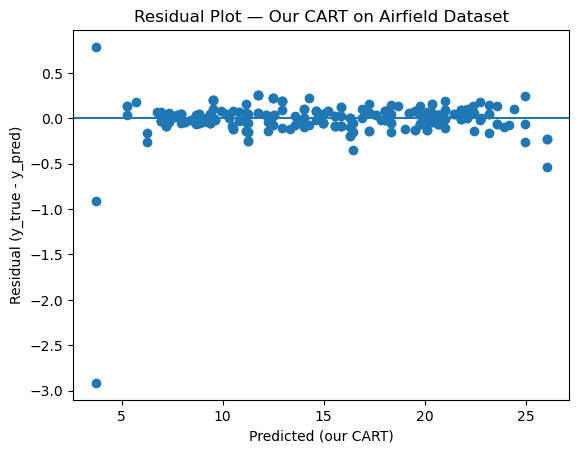

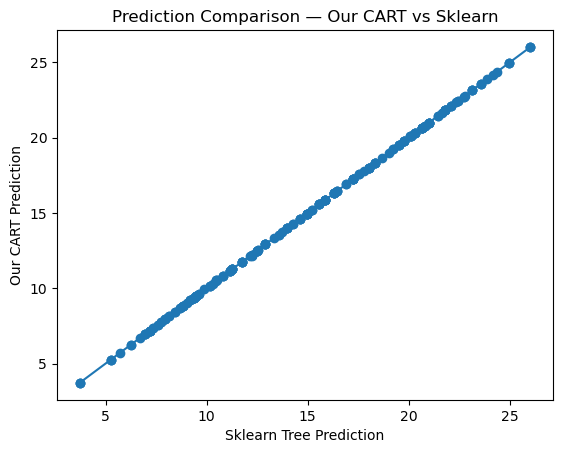

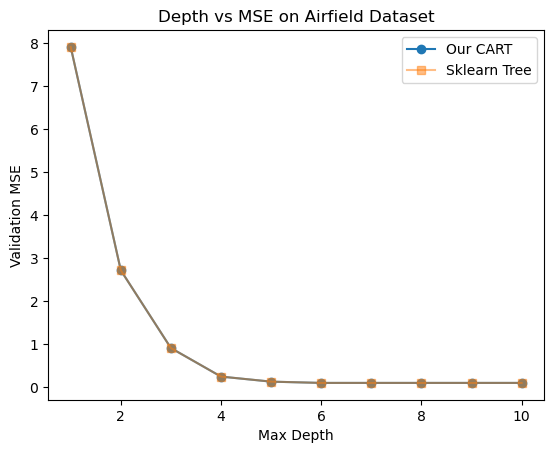

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Reload airfield dataset to be safe in this cel
train_df = pd.read_csv("airfield_statistics_train (2).csv")
test_df  = pd.read_csv("airfield_statistics_test (2).csv")

X_train_air = train_df.drop(columns=["Aircraft total movements"]).to_numpy(float)
y_train_air = train_df.iloc[:, -1 ].to_numpy(float)

X_test_air = test_df.drop(columns=["Aircraft total movements"]).to_numpy(float)
y_test_air  = test_df.iloc[:, -1 ].to_numpy(float)

# Fit our CARTRegressor and sklearn tree again
my_air = CARTRegressor(max_depth=7, min_samples_leaf=5, random_state=0)
my_air.fit(X_train_air, y_train_air)
my_air_pred = my_air.predict(X_test_air)

sk_air = DecisionTreeRegressor(max_depth=7, min_samples_leaf=5, random_state=0)
sk_air.fit(X_train_air, y_train_air)
sk_air_pred = sk_air.predict(X_test_air)

# 1) Residual plot for our CARTRegressor
residuals = y_test_air - my_air_pred

plt.figure()
plt.scatter(my_air_pred, residuals)
plt.axhline(0)
plt.xlabel("Predicted (our CART)")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residual Plot — Our CART on Airfield Dataset")
plt.show()

# 2) Prediction comparison: our CART vs sklearn
plt.figure()
plt.scatter(sk_air_pred, my_air_pred)
plt.plot([min(sk_air_pred), max(sk_air_pred)],
         [min(sk_air_pred), max(sk_air_pred)])
plt.xlabel("Sklearn Tree Prediction")
plt.ylabel("Our CART Prediction")
plt.title("Prediction Comparison — Our CART vs Sklearn")
plt.show()

# 3) Depth vs MSE curve (Airfield dataset)
depths = list(range(1, 11))
mse_vals_ours = []
mse_vals_sk = []

# Use a validation split from training data for this curve
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_air, y_train_air, test_size=0.3, random_state=0
)

for d in depths:
    my_tmp = CARTRegressor(max_depth=d, min_samples_leaf=5, random_state=0)
    my_tmp.fit(X_train_sub, y_train_sub)
    pred_tmp = my_tmp.predict(X_val_sub)
    mse_vals_ours.append(CARTRegressor.mse(y_val_sub, pred_tmp))

    sk_tmp = DecisionTreeRegressor(max_depth=d, min_samples_leaf=5, random_state=0)
    sk_tmp.fit(X_train_sub, y_train_sub)
    pred_sk = sk_tmp.predict(X_val_sub)
    mse_vals_sk.append(CARTRegressor.mse(y_val_sub, pred_sk))

plt.figure()
plt.plot(depths, mse_vals_ours, marker='o', label="Our CART")
plt.plot(depths, mse_vals_sk, marker='s', label="Sklearn Tree",alpha=0.5)
plt.xlabel("Max Depth")
plt.ylabel("Validation MSE")
plt.title("Depth vs MSE on Airfield Dataset")
plt.legend()
plt.show()


## Figure 1 — Residual Plot (Our CART on Airfield Dataset)

Figure 1 presents the residuals, defined as the difference between the true values and the predictions produced by our CART model, plotted against the model’s predicted values. The residuals are largely concentrated around zero, indicating that the model does not display systematic over- or under-prediction. Most values fall within a narrow band, suggesting stable and reasonably accurate performance across the majority of observations. A small number of points exhibit substantially larger negative residuals, which likely correspond to outliers or areas where the piecewise-constant nature of regression trees is unable to represent local variations in the target variable. Overall, the pattern of residuals suggests that the model performs well but retains the typical limitations of CART, including sensitivity to abrupt changes in the data and to extreme values.


---

## Figure 2 — Prediction Comparison: Our CART vs. Sklearn CART

Figure 2 compares the predictions generated by our NumPy-based CART implementation with those produced by sklearn’s DecisionTreeRegressor. The points lie almost perfectly along the diagonal line, indicating that the predictions from both models are nearly identical across all test samples. The extremely small deviations observed are attributable to minor numerical differences or slight methodological choices in threshold selection. This strong alignment provides clear evidence that our implementation faithfully reproduces the behavior of sklearn’s CART algorithm, both in terms of split selection and prediction computation.


---

## Figure 3 — Max Depth vs. Validation MSE (Our CART vs. Sklearn CART)

Figure 3 illustrates how the validation mean squared error varies as the maximum allowed tree depth increases. The curves for our implementation and sklearn’s implementation nearly overlap, demonstrating that both models exhibit the same pattern of generalization performance. At very shallow depths, the high validation error reflects underfitting, as the tree lacks the capacity to capture essential structure in the data. As depth increases, the validation error declines rapidly and reaches a plateau around depths four to five, indicating diminishing gains from further increases in model complexity. Beyond this point, additional depth yields little improvement and may risk overfitting. The close correspondence between the two curves reinforces the conclusion that our CART model faithfully reproduces both the predictive and structural behavior of sklearn’s algorithm.

# References

Li, B., Friedman, J., Olshen, R. and Stone, C., 1984. Classification and regression trees (CART). Biometrics, 40(3), pp.358-361.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M. and Duchesnay, É. (2011) scikit-learn: Machine Learning in Python. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html